Trying data smoothing, didnt work

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from itertools import chain
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
#import keras_tuner as kt
df = pd.read_csv("drive/MyDrive/Engineer's Project/test.csv")

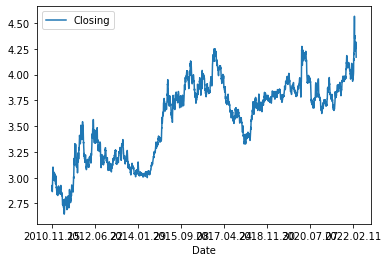

In [ ]:
df.plot(x='Date', y='Closing')

In [ ]:
df.pop('usa_cpi')
df.pop('pol_cpi')
df.pop('usa_inter')
df.pop('pol_inter')
df.pop('Date')

0       2010.11.15
1       2010.11.16
2       2010.11.17
3       2010.11.18
4       2010.11.19
           ...    
3537    2022.03.27
3538    2022.03.28
3539    2022.03.29
3540    2022.03.30
3541    2022.03.31
Name: Date, Length: 3542, dtype: object

In [ ]:
float_data = np.array(df).astype('float32')

In [ ]:
train_data = float_data[:3001]
test_data  = float_data[3001:]

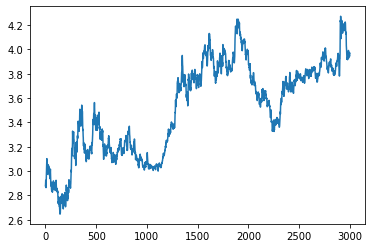

In [ ]:
plt.plot(train_data[:,3])

In [ ]:
scaler = MinMaxScaler()
smoothing_window_size = 100
for di in range (0,3000,smoothing_window_size):
  scaler.fit(train_data[di:di+smoothing_window_size,:])
  train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])
#test data = scaler transform(float_data[3001:] transform test data

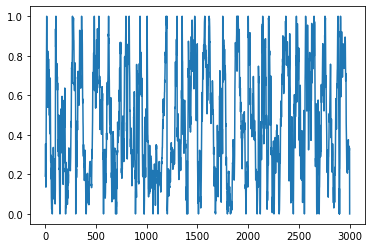

In [ ]:
plt.plot(train_data[:,3])

In [ ]:
test_data = scaler.transform(test_data)
#test data = scaler transform(float_data[3001:] transform test data

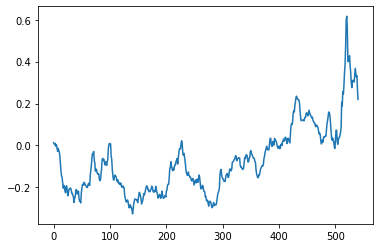

In [ ]:
plt.plot(test_data[:,3])

In [ ]:
scaler = MinMaxScaler()
df_numpy = df.to_numpy() 
#len(df_numpy[:2500])
scaler1 = scaler.fit(df_numpy[:3000])
df_scalled = scaler1.transform(df_numpy)
#df_scaled_all = scaler.
df_scalled = pd.DataFrame(df_scalled, columns=[
  'Opening', 'High', 'Low', 'Closing','Momentum', 'Range', 'ohlc'])

In [ ]:
lookback = 15
step = 1
delay = 1
batch_size = 128

In [ ]:
def generator(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=1):
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback
  while 1:
    if shuffle:
      rows = np.random.randint(
        min_index + lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)
    samples = np.zeros((len(rows),lookback // step,data.shape[-1]))
    targets = np.zeros((len(rows),))
    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][3] ##### HIT KURDE 1 to numer kolumny ktora przewiduje wtf
    yield samples, targets

In [ ]:
train_gen = generator(train_data,
lookback=lookback,
delay=delay,
min_index=0,
max_index=2501,
#shuffle=True,
step=step,
batch_size=batch_size)

In [ ]:
val_gen = generator(train_data,
lookback=lookback,
delay=delay,
min_index=2501,
max_index=3001,
step=step,
batch_size=batch_size)

In [ ]:
test_gen = generator(test_data,
lookback=lookback,
delay=delay,
min_index=0,
max_index=540,
step=step,
batch_size=batch_size)

In [ ]:
train_steps = (2501 - lookback)
val_steps = (3001 - 2501 - lookback)
test_steps = (540 - lookback)

In [ ]:
del model

In [ ]:
model = tf.keras.models.Sequential()
model.add(layers.LSTM(120,
  activation='sigmoid',
  #dropout=0.1,
  #recurrent_dropout=0.1,
  input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(5,
  activation='sigmoid',))
model.add(layers.Dense(1,
  activation='sigmoid'))
model.compile(optimizer= tf.keras.optimizers.RMSprop(0.01), loss='mae')
history = model.fit(train_gen,
  steps_per_epoch=200,
  epochs=200,
  validation_data=val_gen,
  validation_steps=val_steps)

Epoch 1/200
200/200 [==============================] - 19s 81ms/step - loss: 0.1322 - val_loss: 0.1100
Epoch 2/200
200/200 [==============================] - 13s 67ms/step - loss: 0.0841 - val_loss: 0.0884
Epoch 3/200
200/200 [==============================] - 13s 67ms/step - loss: 0.0801 - val_loss: 0.0972
Epoch 4/200
200/200 [==============================] - 13s 67ms/step - loss: 0.0780 - val_loss: 0.0869
Epoch 5/200
200/200 [==============================] - 13s 67ms/step - loss: 0.0771 - val_loss: 0.0945
Epoch 6/200
200/200 [==============================] - 13s 67ms/step - loss: 0.0766 - val_loss: 0.0867
Epoch 7/200
200/200 [==============================] - 14s 68ms/step - loss: 0.0758 - val_loss: 0.0883
Epoch 8/200
200/200 [==============================] - 13s 67ms/step - loss: 0.0756 - val_loss: 0.0945
Epoch 9/200
200/200 [==============================] - 14s 68ms/step - loss: 0.0744 - val_loss: 0.0884
Epoch 10/200
200/200 [==============================] - 13s 67ms/step - l

In [ ]:
eval = model.evaluate(test_gen, steps = test_steps)

525/525 [==============================] - 9s 16ms/step - loss: 0.1749
